## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## First, I'll define helper methods

In [28]:
def print_image_grid(images, columns=3):
    """
    A helper method for drawing multiple images in a grid
    """
    f = plt.figure(figsize=(20, 100)) # width, height in inches. If not provided, defaults to rc figure.figsize.
    for i, img in enumerate(images):
        splt = plt.subplot(len(images) / columns + 1, columns, i + 1)
        splt.set_title(img[0], fontsize=20)
        if len(img[1].shape) > 2:
            splt.imshow(img[1])
        else:
            splt.imshow(img[1], cmap='gray')

## Then I'll compute the camera calibration using chessboard images

In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt4
%matplotlib inline

chessboard_nx = 9
chassboard_ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chassboard_ny*chessboard_nx,3), np.float32)
objp[:,:2] = np.mgrid[0:chessboard_nx,0:chassboard_ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

img_shape = None

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_shape = gray.shape[::-1]

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chessboard_nx,chassboard_ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (chessboard_nx,chassboard_ny), corners, ret)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

# Camera calibration, given object points, image points, and the shape of the grayscale image
ret, cc_mtx, cc_dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
if not ret:
    raise Exception("Cannot calibrate camera")
print("Calibration succeeded")

Calibration succeeded


## And define the method for undistoring images

In [6]:
def undistort(img):
    """
    Distortion correction using the parameters gotten after camera calibration
    returns an undistorted image
    """
    return cv2.undistort(img, cc_mtx, cc_dist, None, cc_mtx)

## Then I'll choose parameters for perspective transformation

Lane width: 550px
Resolution: 0.00673 m/px


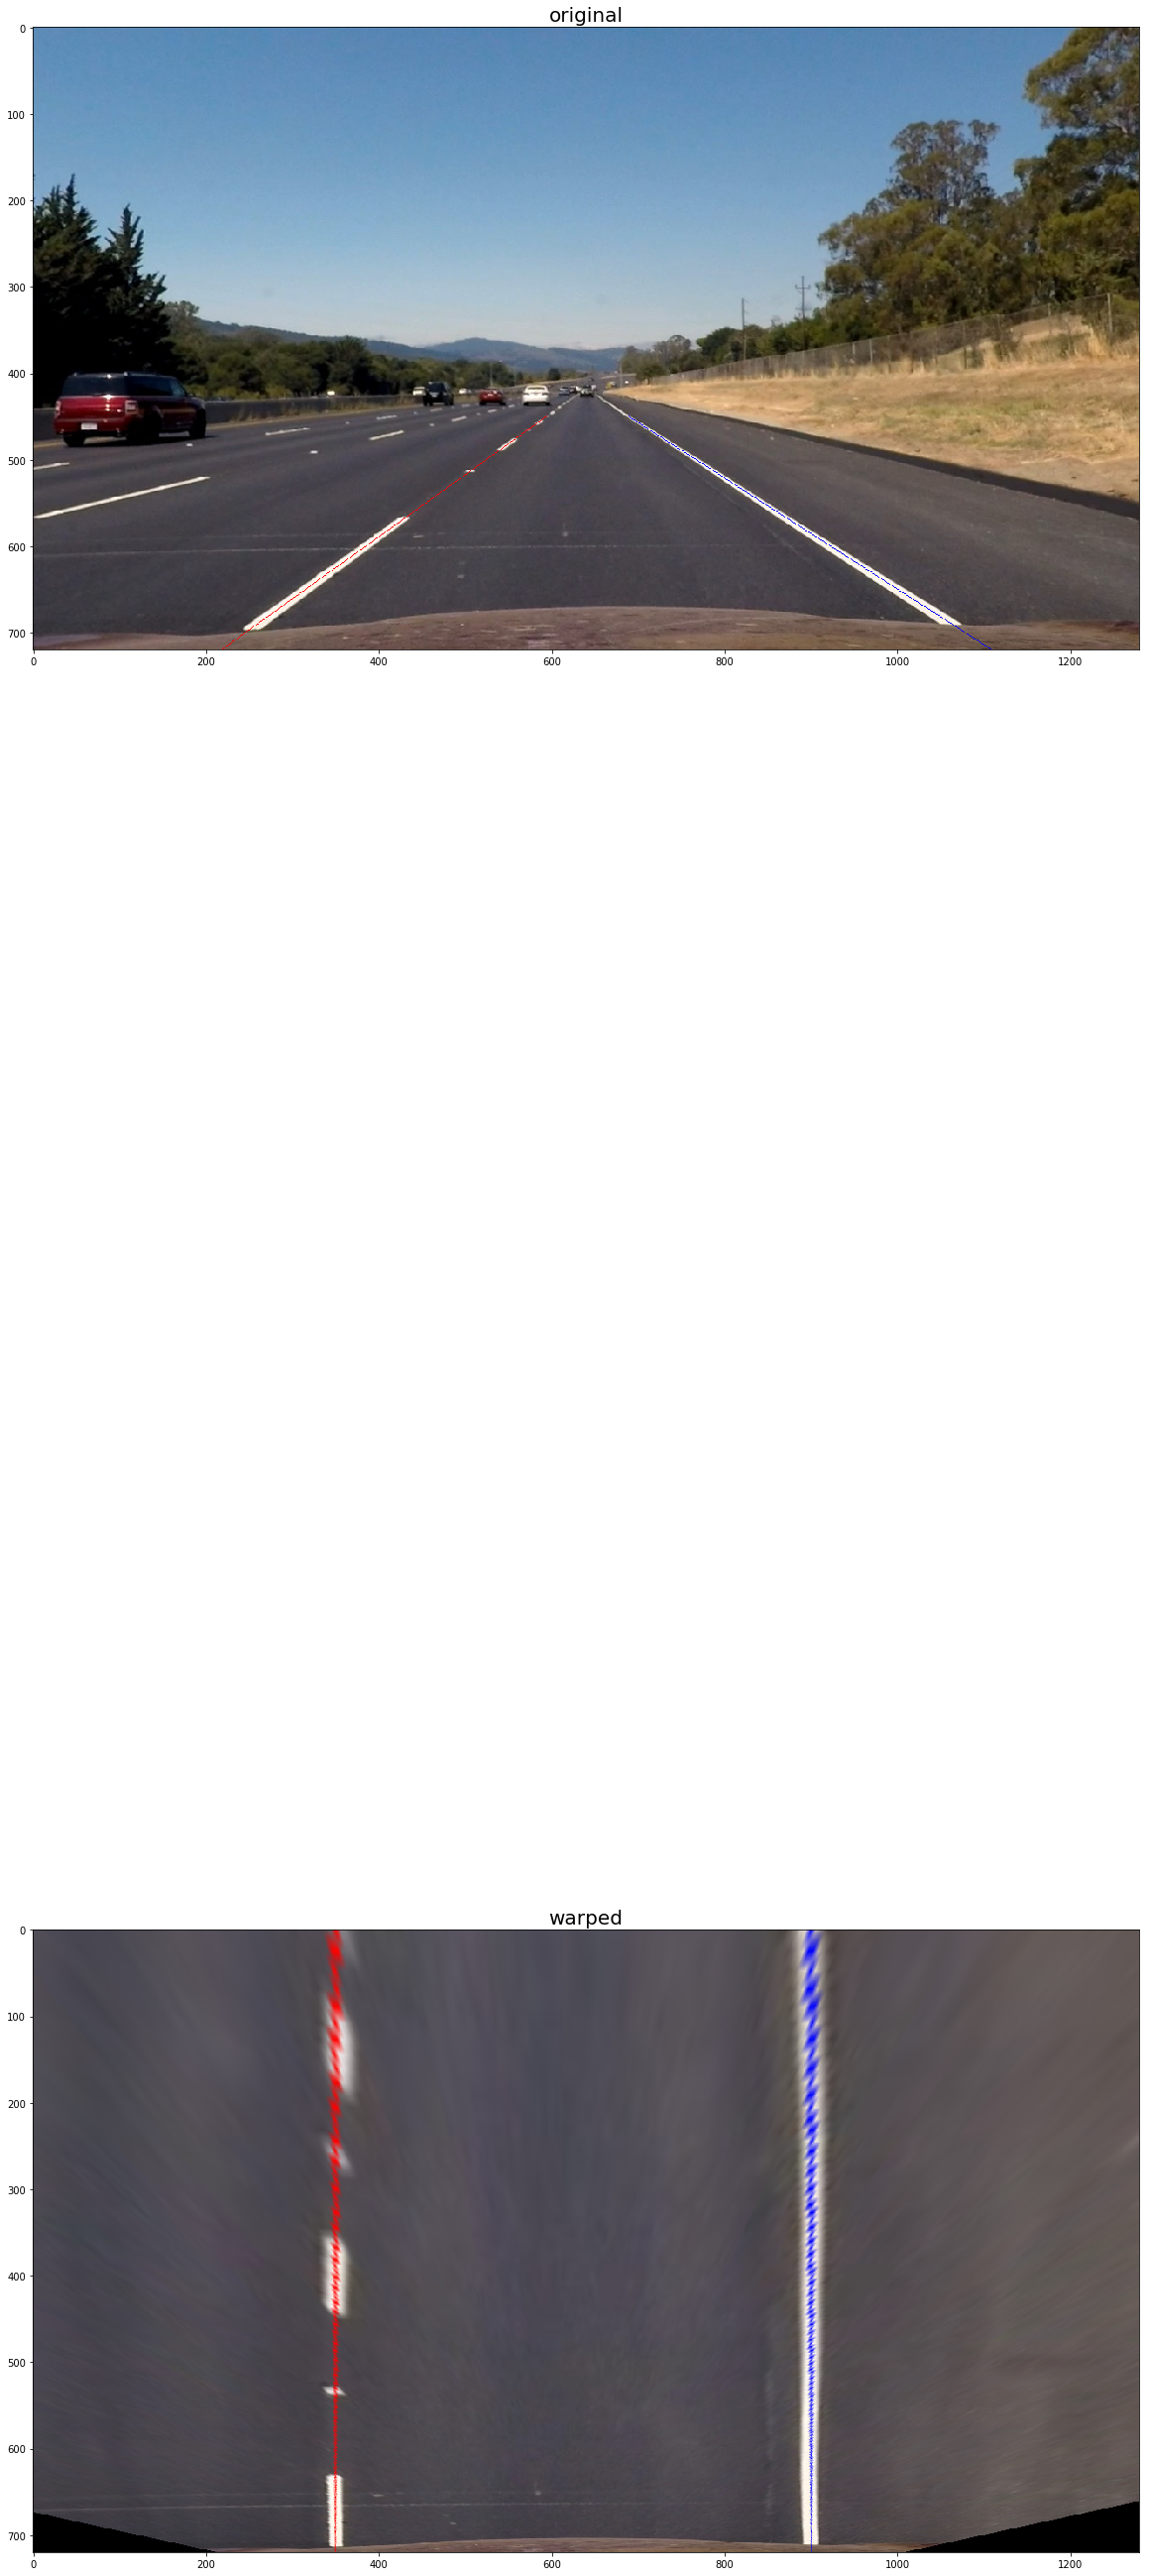

In [361]:
# Choosing parameters for perpective transformation
fname = './test_images/straight_lines2.jpg'
img = mpimg.imread(fname)

img_undistorted = undistort(img)
img_height = img_undistorted.shape[0]

top_y = 450

#lx1 = 200
#ly1 = img_height
#lx2 = 592
#ly2 = top_y
#cv2.line(img_undistorted, (lx1, ly1), (lx2, ly2), color=[255,0,0], thickness=1)

#rx1 = 1126
#ry1 = img_height
#rx2 = 692
#ry2 = top_y
#cv2.line(img_undistorted, (rx1, ry1), (rx2, ry2), color=[0,0,255], thickness=1)

lx1 = 218
ly1 = img_height
lx2 = 594
ly2 = top_y
cv2.line(img_undistorted, (lx1, ly1), (lx2, ly2), color=[255,0,0], thickness=1)

rx1 = 1109
ry1 = img_height
rx2 = 689
ry2 = top_y
cv2.line(img_undistorted, (rx1, ry1), (rx2, ry2), color=[0,0,255], thickness=1)

src = np.float32([
    [lx1, ly1], # bottom left
    [lx2, ly2], # top left
    [rx2, ry2], # top right
    [rx1, ry1]  # bottom right
]) 

lwx = 350 # left warped x-coordinate
rwx = 900 # right warped x-coordinate
dst = np.float32([
    [lwx, img_height], # bottom left
    [lwx, 0],          # top left
    [rwx, 0],          # top right
    [rwx, img_height]  # bottom right
])

warped_lane_width_px = rwx - lwx # lane width in pixels
warped_xm_per_px = 3.7 / warped_lane_width_px # the number of meters in a pixel

print('Lane width: %dpx' % warped_lane_width_px)
print('Resolution: %0.5f m/px' % warped_xm_per_px)

M = cv2.getPerspectiveTransform(src, dst)
Minv = np.linalg.inv(M)

img_size = (img_undistorted.shape[1], img_undistorted.shape[0])
img_warped = cv2.warpPerspective(img_undistorted, M, img_size, flags=cv2.INTER_LINEAR)

print_image_grid([('original', img_undistorted), ('warped', img_warped)], 1)

## And define a method for the transformation

In [51]:
def birds_eye_view(img):
    img_size = (img.shape[1], img.shape[0])
    img_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return img_warped

## Let's find a region of interest

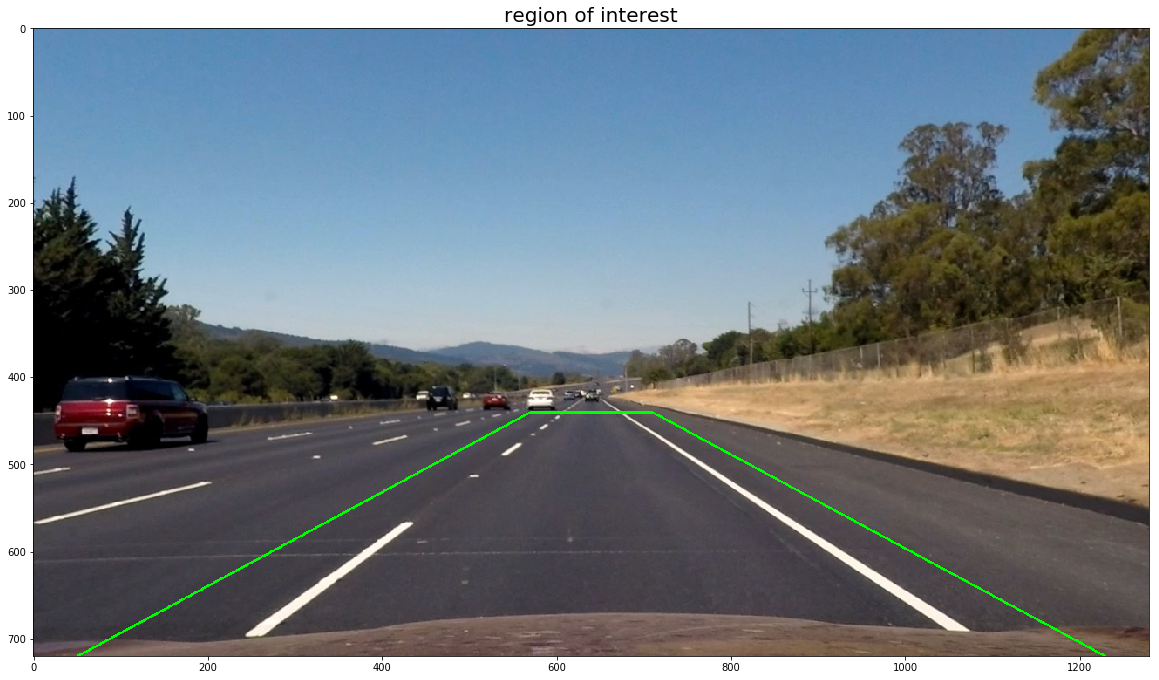

In [52]:
fname = './test_images/straight_lines2.jpg'
img = mpimg.imread(fname)

img_undist = undistort(img)
img_height = img_undist.shape[0]
img_width = img_undist.shape[1]

color = [0,255,0]
thickness = 2

ror_height = 440

x1 = 50
y1 = img_height
x2 = 570
y2 = ror_height
x3 = 710
y3 = ror_height
x4 = img_width - 50
y4 = img_height

cv2.line(img_undist, (x1, y1), (x2, y2), color=color, thickness=thickness)
cv2.line(img_undist, (x2, y2), (x3, y3), color=color, thickness=thickness)
cv2.line(img_undist, (x3, y3), (x4, y4), color=color, thickness=thickness)

print_image_grid([('region of interest', img_undist)], 1)

ror_vertices = np.array([[(x1,y1),(x2,y2),(x3,y3),(x4,y4)]], dtype=np.int32)

## And define a method for filtering the region of interest (ROR)

In [11]:
def region_of_interest(img, vertices=ror_vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Next step is defining a pipeline for processing a single image frame

In [206]:
def grayscale(img):
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            
def to_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
def scale_sobel(abs_sobel):
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return scaled_sobel
    
def gray_to_sobel(gray, orient='x', ksize=3):
    if orient == 'x':
        ox = 1
        oy = 0
    else:
        ox = 0
        oy = 1
    return cv2.Sobel(gray, cv2.CV_64F, ox, oy, ksize=ksize)
    
def gray_to_scaled_sobel(gray, orient='x', ksize=3):
    sobel = gray_to_sobel(gray, orient, ksize)
    abs_sobel = np.absolute(sobel)
    return scale_sobel(abs_sobel)
    
def gray_to_scaled_mag(gray, ksize=3):
    sobelx = gray_to_sobel(gray, 'x', ksize)
    sobely = gray_to_sobel(gray, 'y', ksize)    
    sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    return scale_sobel(sobel)
    
def bin_mask(img, thresh=[0, 255]):
    bin_img = np.zeros_like(img)
    bin_img[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return bin_img
    
def grad_direction(gray, ksize=3):
    """
    An orientation of 0 implies a vertical line and orientations of +/−π/2 imply horizontal lines
    """
    sobelx = gray_to_sobel(gray, 'x', ksize)
    sobely = gray_to_sobel(gray, 'y', ksize)    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)    
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    return grad_dir

def curvature_radius(y, fit):
    return (1 + (2*fit[0]*y + fit[1])**2)**(3/2) / np.absolute(2*fit[0])  

def polinomial(y, fit):
    return fit[0]*y**2 + fit[1]*y + fit[2] 

In [112]:
class Line():
    def __init__(self, allx, ally):
        #x values for detected line pixels
        self.allx = allx
        #y values for detected line pixels
        self.ally = ally        
        #polynomial coefficients for fit
        self.fit = np.polyfit(ally, allx, 2)

# Define a class to receive the characteristics of each line detection
class LineDetector():
    def __init__(self, history_depth, img_height_px, img_width_px, xm_per_pix, ym_per_pix):
        # the number of last measurements which will be stored
        self.history_depth = history_depth
        # image height in pixels
        self.img_height_px = img_height_px
        # image width in pixels
        self.img_width_px = img_width_px
        # meters per pixel in x dimension
        self.xm_per_pix = xm_per_pix
        # meters per pixel in y dimension
        self.ym_per_pix = ym_per_pix
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # average x values of the fitted line over the last n iterations
        self.bestx = None   
        # polynomial coefficients of the last n iterations
        self.recent_fits = []
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        # distance in meters of vehicle center from the line
        self.line_base_pos = 0
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        
    def update(self, line):
        self.current_line = line
        self.detected = line is not None
        if self.detected:
            self.recent_fits.append(line.fit)
            if len(self.recent_fits) > self.history_depth:
                self.recent_fits = self.recent_fits[1:]
            self.best_fit = np.mean(self.recent_fits, axis=0)
            
            # calculating radius of curvature
            lane_length_m = self.ym_per_pix * self.img_height_px
            self.radius_of_curvature = int(curvature_radius(lane_length_m, self.best_fit))
            
            # calculating line base position
            fit = self.best_fit
            y_pos = self.img_height_px
            line_pos_px = fit[0]*y_pos**2 + fit[1]*y_pos + fit[2]
            line_base_pos_px = line_pos_px - (self.img_width_px / 2)
            self.line_base_pos = line_base_pos_px * self.xm_per_pix
            

True
(True, 3.9540194745614543)


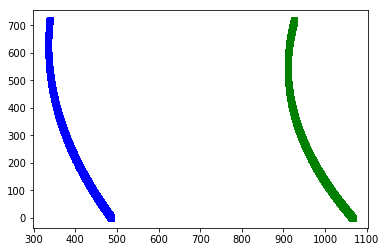

In [344]:
def sanity_check_curvature(left_fit, right_fit, y_pos):
    strait_after_px = 1000
    left_rad = curvature_radius(y_pos, left_fit)
    right_rad = curvature_radius(y_pos, right_fit)
    
    #print('left_rad: ', left_rad)
    #print('right_rad: ', right_rad)    
    
    if left_rad > strait_after_px and right_rad > strait_after_px:
        return True
    
    err = np.absolute(left_rad - right_rad)  
    max_err = 0.0004 * ((left_rad +right_rad)/2)**2
    #print('max_err: ', max_err)    
    passed = err <= max_err
    #if not passed:
        #print('Curvature check failed, err > max_err (%0.2f > %0.2f). l=%0.2f, r=%0.2f' % (err, max_err, left_rad, right_rad))
    return passed

def sanity_check_distance(left_fit, right_fit, y_pos):
    left_pos = polinomial(y_pos, left_fit)
    right_pos = polinomial(y_pos, right_fit)
    distance_px = right_pos - left_pos
    diff_px = np.absolute(warped_lane_width_px - distance_px)
    diff_m = diff_px * warped_xm_per_px # diff in meters
    passed = diff_m < 0.5 # allows 50cm diff
    #if not passed:
        #print('Distance check failed, diff_m=', diff_m)
    return passed, distance_px * warped_xm_per_px

def sanity_check(left_line, right_line, y_pos):
    # Checking that they have similar curvature
    #if not sanity_check_curvature(left_line.fit, right_line.fit, y_pos):
    #    return False
    
    # Checking that they are separated by approximately the right distance horizontally
    #if not sanity_check_distance(left_line.fit, right_line.fit, y_pos):
    #    return False
    
    # Checking that they are roughly parallel
    return True


#left:  [ 3.84049533e-04 -4.82746648e-01  4.86829461e+02]
#right:  [ 5.22020818e-04 -5.70486039e-01  1.06623716e+03]

left_fit = np.array([3.84049533e-04, -4.82746648e-01, 4.86829461e+02])
right_fit = np.array([5.22020818e-04, -5.70486039e-01, 1.06623716e+03])

print(sanity_check_curvature(left_fit, right_fit, 30))
print(sanity_check_distance(left_fit, right_fit, 720))

ploty = np.linspace(0, 720-1, 720)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    
l_pts = np.vstack((left_fitx,ploty)).astype(np.int32).T
r_pts = np.vstack((right_fitx,ploty)).astype(np.int32).T
plt.plot(left_fitx, ploty, 'bs', right_fitx, ploty, 'gs')

In [289]:
def thresh(img):
    """
    returns a thresholded image and a list of steps
    """
    steps = []
    
    gray = grayscale(img)
    steps.append(('gray', gray))
    
    # RGB
    img_r = img[:,:,0]
    steps.append(('RGB_R', img_r))
    img_g = img[:,:,1]
    steps.append(('RGB_G', img_g))    
    img_b = img[:,:,2]    
    steps.append(('RGB_B', img_b))    
    
    # HLS
    hls = to_hls(img)
    hls_h = hls[:,:,0]
    steps.append(('HLS_H', hls_h))
    hls_l = hls[:,:,1]
    steps.append(('HLS_L', hls_l))
    hls_s = hls[:,:,2]
    steps.append(('HLS_S', hls_s))    
    
    # sobel x, y, magnitude
    sobelx = gray_to_scaled_sobel(gray, 'x')
    steps.append(('Gray-Sobel X', sobelx))
    sobely = gray_to_scaled_sobel(gray, 'y')
    steps.append(('Gray-Sobel Y', sobely))
    mag = gray_to_scaled_mag(gray)
    steps.append(('Gray-Sobel MAG', mag))
    
    hls_l_sobelx = gray_to_scaled_sobel(hls_l, 'x')
    hls_l_sobelx_thresh = bin_mask(hls_l_sobelx, thresh=[20, 100])
    steps.append(('HLS_L SobelX thresh', hls_l_sobelx_thresh))
    
    hls_s_thresh = bin_mask(hls_s, thresh=[170, 255])
    steps.append(('HLS_S thresh', hls_s_thresh))
    
    result_thresh = np.zeros_like(hls_l_sobelx_thresh)
    result_thresh[(hls_l_sobelx_thresh == 1) | (hls_s_thresh == 1)] = 1
    steps.append(('Result thresh', result_thresh))
    
    return (result_thresh, steps)

def find_lane_pixels(binary_warped):
    height = binary_warped.shape[0]
    
    # Take a histogram of the bottom half of the image
    half_binary_warped = binary_warped[height//2:,:]
    histogram = np.sum(half_binary_warped, axis=0)
    # Create an output image to draw on and visualize the result
    img_lane_pixels = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    img_histogram = np.dstack((half_binary_warped, half_binary_warped, half_binary_warped))*255
    plotx = np.linspace(0, binary_warped.shape[1]-1, binary_warped.shape[1])
    pts = np.vstack((plotx,img_histogram.shape[0]-histogram)).astype(np.int32).T
    cv2.polylines(img_histogram, [pts], isClosed=False, color=[255,0,0], thickness=2)
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = height - (window+1)*window_height
        win_y_high = height - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(img_lane_pixels,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(img_lane_pixels,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    img_lane_pixels[lefty, leftx] = [255, 0, 0]
    img_lane_pixels[righty, rightx] = [0, 0, 255]
    
    left_line = Line(leftx, lefty)
    right_line = Line(rightx, righty)
    
    try:
        left_fit = left_line.fit
        right_fit = right_line.fit
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, height-1, height)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    
        l_pts = np.vstack((left_fitx,ploty)).astype(np.int32).T
        r_pts = np.vstack((right_fitx,ploty)).astype(np.int32).T
        cv2.polylines(img_lane_pixels, [l_pts], isClosed=False, color=[255,255,0])
        cv2.polylines(img_lane_pixels, [r_pts], isClosed=False, color=[255,255,0])
    except Exception:
        pass    
    
    return left_line, right_line, img_lane_pixels, img_histogram

def search_around_poly(binary_warped, left_fit, right_fit):
    margin = 100
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    ax = left_fit[0]
    bx = left_fit[1]
    cx = left_fit[2]
    left_lane_inds = ((nonzerox >= ax*nonzeroy**2 + bx*nonzeroy + cx - margin) & 
    (nonzerox < ax*nonzeroy**2 + bx*nonzeroy + cx + margin))
    
    ax = right_fit[0]
    bx = right_fit[1]
    cx = right_fit[2]
    right_lane_inds = ((nonzerox >= ax*nonzeroy**2 + bx*nonzeroy + cx - margin) & 
    (nonzerox < ax*nonzeroy**2 + bx*nonzeroy + cx + margin)) 
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]    
    
    left_line = Line(leftx, lefty)
    right_line = Line(rightx, righty)
    
    return left_line, right_line

In [347]:
def pipeline(img, left_det=None, right_det=None):
    width = img.shape[1]
    height = img.shape[0]
    
    history_depth = 1
    img_height_px = height
    img_width_px = width
    xm_per_pix = 3.7 / warped_lane_width_px 
    ym_per_pix = 30. / height
    
    if left_det is None:
        left_det = LineDetector(history_depth, img_height_px, img_width_px, xm_per_pix, ym_per_pix)
    
    if right_det is None:
        right_det = LineDetector(history_depth, img_height_px, img_width_px, xm_per_pix, ym_per_pix)
    
    steps = []
    
    steps.append(('original', img))
    
    # Applying a distortion correction to the raw image.
    img_undist = undistort(img)
    steps.append(('undistorted', img_undist))
    
    # Use color transforms, gradients, etc., to create a thresholded binary image.
    img_thresholded, thr_steps = thresh(img_undist)
    steps.extend(thr_steps)
    
    # Filtering the region of interest
    img_ror = region_of_interest(img_thresholded)
    steps.append(('region of interest', img_ror))    
    
    # Apply a perspective transform to rectify binary image ("birds-eye view").
    img_warped = birds_eye_view(img_ror)
    steps.append(('warped', img_warped))
    
    # Find our lane pixels first
    if False and left_det.detected and right_det.detected:
        lline, rline = search_around_poly(img_warped, left_det.best_fit, right_det.best_fit)
    else:
        lline, rline, img_lane_pixels, img_histogram = find_lane_pixels(img_warped)
        steps.append(('histogram', img_histogram))
        steps.append(('lane pixels', img_lane_pixels))
    
    # Checking if the lines are correct
    if sanity_check(lline, rline, height):
        left_det.update(lline)
        right_det.update(rline)
    else:
        print('Sanity check failed')
        left_det.update(None)
        right_det.update(None)
    
    # Determine the curvature of the lane and vehicle position with respect to center.
        
    left_fit = left_det.best_fit
    right_fit = right_det.best_fit
    
    if left_fit is None or right_fit is None:
        return img_undist, steps
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    

    # Warp the detected lane boundaries back onto the original image
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_warped).astype(np.uint8)
    color_warp_poly = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp_lines = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp_poly, np.int_([pts]), (0,255,0))

    color_warp_lines[lline.ally, lline.allx] = [255, 0, 0]
    color_warp_lines[rline.ally, rline.allx] = [100, 0, 255]
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp_poly = cv2.warpPerspective(color_warp_poly, Minv, (width, height)) 
    newwarp_lines = cv2.warpPerspective(color_warp_lines, Minv, (width, height))     
    
    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp_poly, 0.3, 0)
    result = cv2.addWeighted(result, 0.7, newwarp_lines, 0.5, 0)    
    steps.append(('result', result))
    
    left_curverad = left_det.radius_of_curvature
    right_curverad = right_det.radius_of_curvature
    curverad = (left_curverad + right_curverad) // 2
    cv2.putText(result, "Radius of Curvature = %dm" % curverad, (30, 80), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, 
                color=[255,255,255], thickness=2)    
    
    cv2.putText(result, "Radius of Curvature (l) = %dm" % left_curverad, (30, 160), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, 
                color=[255,255,255], thickness=2)  
    
    cv2.putText(result, "Radius of Curvature (r) = %dm" % right_curverad, (30, 240), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, 
                color=[255,255,255], thickness=2)      
    
    check_rad = sanity_check_curvature(left_fit, right_fit, height)
    check_dist, width_m = sanity_check_distance(left_fit, right_fit, height)
    
    cv2.putText(result, "check_rad = %d" % check_rad, (30, 320), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, 
                color=[255,255,255], thickness=2)       
    
    cv2.putText(result, "check_dist = %d" % check_dist, (30, 400), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, 
                color=[255,255,255], thickness=2)  
    
    cv2.putText(result, "width = %0.2fm" % width_m, (30, 480), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, 
                color=[255,255,255], thickness=2)      
    
    # Calculating vehicle position with respect to center.
    position_m = (right_det.line_base_pos + left_det.line_base_pos) / 2
    
    if position_m > 0:
        side = "left"
    else:
        side = "right"
    #cv2.putText(result, "Vehicle is %0.2fm %s of center" % (np.absolute(position_m), side), (30, 160), 
    #            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, 
    #            color=[255,255,255], thickness=2)
        
    return result, steps

# Testing the pipeline on test images

In [227]:
import os
os.listdir('./test_images/')

['test6.jpg',
 'test5.jpg',
 'test4.jpg',
 'test1.jpg',
 'test3.jpg',
 'test2.jpg',
 'straight_lines2.jpg',
 'straight_lines1.jpg']

Processing  ./test_images/test6.jpg
Processing  ./test_images/test5.jpg
Processing  ./test_images/test4.jpg
Processing  ./test_images/test1.jpg
Processing  ./test_images/test3.jpg
Processing  ./test_images/test2.jpg
Processing  ./test_images/straight_lines2.jpg
Processing  ./test_images/straight_lines1.jpg


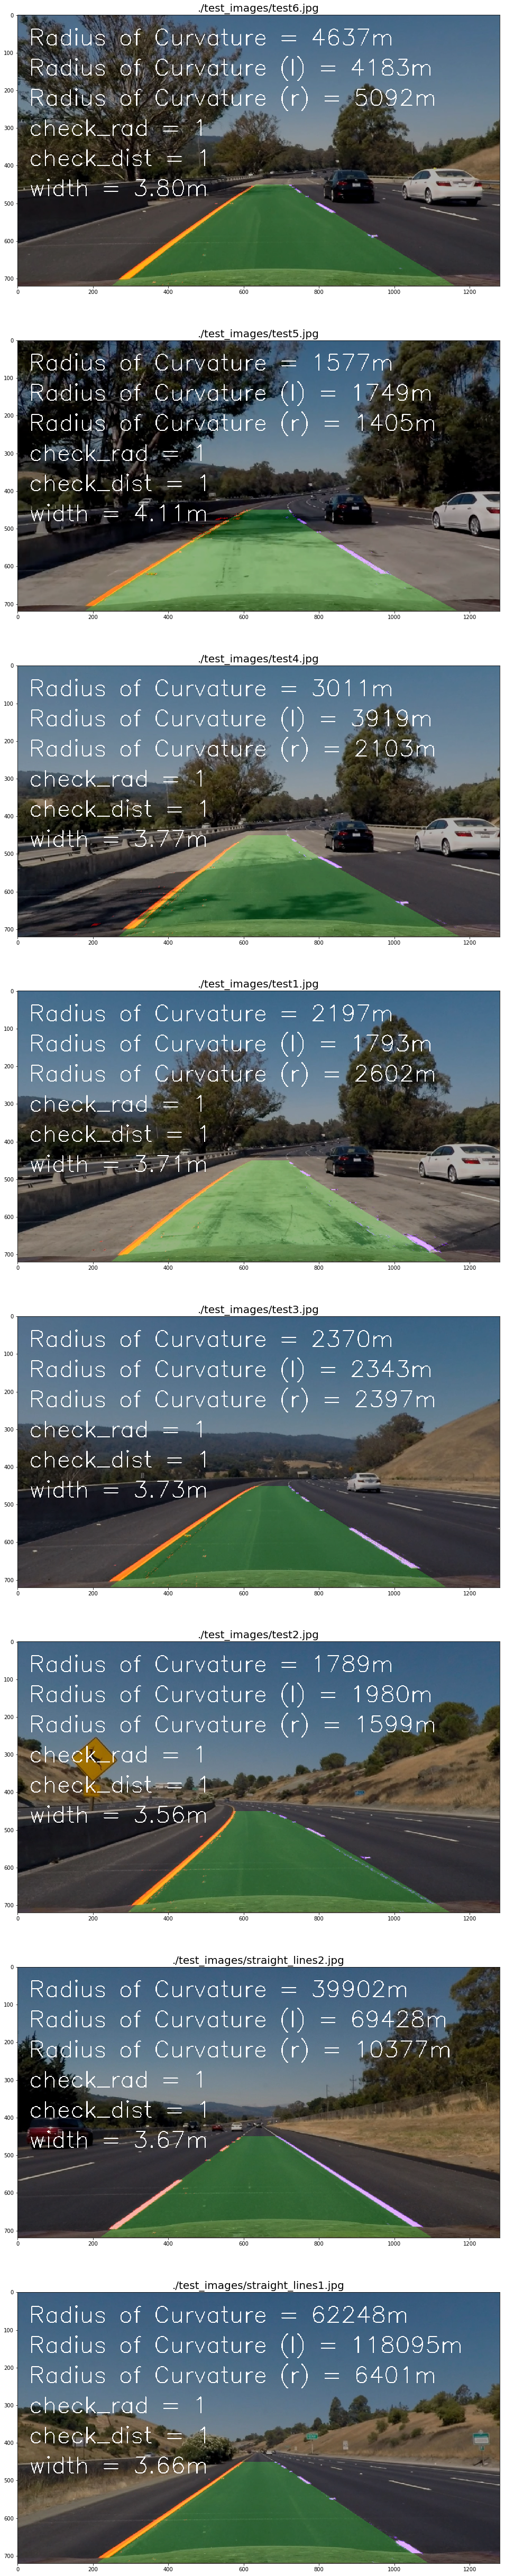

In [362]:
debug_one = False
#debug_image = './test_images/straight_lines1.jpg'
debug_image = './test_images/test4.jpg'
print_steps = debug_one
print_result = not print_steps

test_images = glob.glob('./test_images/*.jpg')
results = []
for fname in test_images:
    if debug_one and fname != debug_image:
        continue
    print('Processing ', fname)
    img = mpimg.imread(fname)
    result, steps = pipeline(img)
    results.append((fname, result))
    if print_steps:
        print_image_grid(steps, 2)
    
if print_result:
    print_image_grid(results, 1)

# Applying the pipeline to the project video

In [273]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_det = None
right_det = None
def process_image(image):
    global left_det
    global right_det
    if left_det is None or right_det is None:
        print('Initializing line detectors')
        history_depth = 5
        img_height_px = image.shape[0]
        img_width_px = image.shape[1]
        xm_per_pix = 3.7 / warped_lane_width_px 
        ym_per_pix = 30. / img_height_px        
        left_det = LineDetector(history_depth, img_height_px, img_width_px, xm_per_pix, ym_per_pix)
        right_det = LineDetector(history_depth, img_height_px, img_width_px, xm_per_pix, ym_per_pix)
        
    result, _ = pipeline(image, left_det, right_det)
    return result

In [365]:
left_det = None
right_det = None

#filename = 'harder_challenge_video.mp4'
#filename = 'challenge_video.mp4'
filename = 'project_video.mp4'

white_output = 'output_videos/%s' % filename
#clip1 = VideoFileClip(filename).subclip(0,5) # the first five seconds for debugging
#clip1 = VideoFileClip(filename).subclip(28,35)
clip1 = VideoFileClip(filename)

white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

Initializing line detectors
[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<03:31,  5.97it/s]

  0%|          | 2/1261 [00:00<03:33,  5.90it/s]

  0%|          | 3/1261 [00:00<03:29,  6.01it/s]

  0%|          | 4/1261 [00:00<03:27,  6.07it/s]

  0%|          | 5/1261 [00:00<03:24,  6.14it/s]

  0%|          | 6/1261 [00:00<03:23,  6.18it/s]

  1%|          | 7/1261 [00:01<03:20,  6.25it/s]

  1%|          | 8/1261 [00:01<03:18,  6.30it/s]

  1%|          | 9/1261 [00:01<03:17,  6.34it/s]

  1%|          | 10/1261 [00:01<03:16,  6.36it/s]

  1%|          | 11/1261 [00:01<03:16,  6.35it/s]

  1%|          | 12/1261 [00:01<03:15,  6.37it/s]

  1%|          | 13/1261 [00:02<03:15,  6.38it/s]

  1%|          | 14/1261 [00:02<03:15,  6.37it/s]

  1%|          | 15/1261 [00:02<03:15,  6.37it/s]

  1%|▏         | 16/1261 [00:02<03:15,  6.38it/s]

  1%|▏         | 17/1261 [00:02<03:14,  6.40it/s]

  1%|▏         | 18/1261 [00:02<03:13,  6.42it/s]

  2%|▏         | 19/1261 [00:02<03:13,  6.42it/

 11%|█▏        | 143/1261 [00:21<02:50,  6.54it/s]

 11%|█▏        | 144/1261 [00:22<02:50,  6.54it/s]

 11%|█▏        | 145/1261 [00:22<02:50,  6.54it/s]

 12%|█▏        | 146/1261 [00:22<02:50,  6.54it/s]

 12%|█▏        | 147/1261 [00:22<02:50,  6.54it/s]

 12%|█▏        | 148/1261 [00:22<02:50,  6.53it/s]

 12%|█▏        | 149/1261 [00:22<02:50,  6.54it/s]

 12%|█▏        | 150/1261 [00:22<02:49,  6.54it/s]

 12%|█▏        | 151/1261 [00:23<02:49,  6.54it/s]

 12%|█▏        | 152/1261 [00:23<02:49,  6.54it/s]

 12%|█▏        | 153/1261 [00:23<02:49,  6.54it/s]

 12%|█▏        | 154/1261 [00:23<02:49,  6.55it/s]

 12%|█▏        | 155/1261 [00:23<02:48,  6.55it/s]

 12%|█▏        | 156/1261 [00:23<02:48,  6.55it/s]

 12%|█▏        | 157/1261 [00:23<02:48,  6.55it/s]

 13%|█▎        | 158/1261 [00:24<02:48,  6.55it/s]

 13%|█▎        | 159/1261 [00:24<02:48,  6.55it/s]

 13%|█▎        | 160/1261 [00:24<02:48,  6.55it/s]

 13%|█▎        | 161/1261 [00:24<02:47,  6.55it/s]

 13%|█▎     

 23%|██▎       | 284/1261 [00:43<02:29,  6.55it/s]

 23%|██▎       | 285/1261 [00:43<02:29,  6.54it/s]

 23%|██▎       | 286/1261 [00:43<02:29,  6.54it/s]

 23%|██▎       | 287/1261 [00:43<02:29,  6.53it/s]

 23%|██▎       | 288/1261 [00:44<02:29,  6.52it/s]

 23%|██▎       | 289/1261 [00:44<02:29,  6.52it/s]

 23%|██▎       | 290/1261 [00:44<02:29,  6.51it/s]

 23%|██▎       | 291/1261 [00:44<02:28,  6.51it/s]

 23%|██▎       | 292/1261 [00:44<02:28,  6.51it/s]

 23%|██▎       | 293/1261 [00:45<02:28,  6.50it/s]

 23%|██▎       | 294/1261 [00:45<02:28,  6.50it/s]

 23%|██▎       | 295/1261 [00:45<02:28,  6.50it/s]

 23%|██▎       | 296/1261 [00:45<02:28,  6.49it/s]

 24%|██▎       | 297/1261 [00:45<02:28,  6.49it/s]

 24%|██▎       | 298/1261 [00:45<02:28,  6.48it/s]

 24%|██▎       | 299/1261 [00:46<02:28,  6.48it/s]

 24%|██▍       | 300/1261 [00:46<02:28,  6.48it/s]

 24%|██▍       | 301/1261 [00:46<02:28,  6.48it/s]

 24%|██▍       | 302/1261 [00:46<02:28,  6.47it/s]

 24%|██▍    

 34%|███▎      | 425/1261 [01:06<02:10,  6.41it/s]

 34%|███▍      | 426/1261 [01:06<02:10,  6.41it/s]

 34%|███▍      | 427/1261 [01:06<02:10,  6.41it/s]

 34%|███▍      | 428/1261 [01:06<02:09,  6.41it/s]

 34%|███▍      | 429/1261 [01:06<02:09,  6.41it/s]

 34%|███▍      | 430/1261 [01:07<02:09,  6.41it/s]

 34%|███▍      | 431/1261 [01:07<02:09,  6.41it/s]

 34%|███▍      | 432/1261 [01:07<02:09,  6.41it/s]

 34%|███▍      | 433/1261 [01:07<02:09,  6.41it/s]

 34%|███▍      | 434/1261 [01:07<02:08,  6.41it/s]

 34%|███▍      | 435/1261 [01:07<02:08,  6.41it/s]

 35%|███▍      | 436/1261 [01:07<02:08,  6.41it/s]

 35%|███▍      | 437/1261 [01:08<02:08,  6.42it/s]

 35%|███▍      | 438/1261 [01:08<02:08,  6.42it/s]

 35%|███▍      | 439/1261 [01:08<02:08,  6.42it/s]

 35%|███▍      | 440/1261 [01:08<02:07,  6.42it/s]

 35%|███▍      | 441/1261 [01:08<02:07,  6.42it/s]

 35%|███▌      | 442/1261 [01:08<02:07,  6.42it/s]

 35%|███▌      | 443/1261 [01:09<02:07,  6.42it/s]

 35%|███▌   

 45%|████▍     | 566/1261 [01:27<01:47,  6.48it/s]

 45%|████▍     | 567/1261 [01:27<01:47,  6.48it/s]

 45%|████▌     | 568/1261 [01:27<01:47,  6.47it/s]

 45%|████▌     | 569/1261 [01:27<01:46,  6.47it/s]

 45%|████▌     | 570/1261 [01:28<01:46,  6.47it/s]

 45%|████▌     | 571/1261 [01:28<01:46,  6.48it/s]

 45%|████▌     | 572/1261 [01:28<01:46,  6.48it/s]

 45%|████▌     | 573/1261 [01:28<01:46,  6.47it/s]

 46%|████▌     | 574/1261 [01:28<01:46,  6.47it/s]

 46%|████▌     | 575/1261 [01:28<01:45,  6.47it/s]

 46%|████▌     | 576/1261 [01:28<01:45,  6.47it/s]

 46%|████▌     | 577/1261 [01:29<01:45,  6.47it/s]

 46%|████▌     | 578/1261 [01:29<01:45,  6.47it/s]

 46%|████▌     | 579/1261 [01:29<01:45,  6.47it/s]

 46%|████▌     | 580/1261 [01:29<01:45,  6.47it/s]

 46%|████▌     | 581/1261 [01:29<01:45,  6.47it/s]

 46%|████▌     | 582/1261 [01:29<01:44,  6.47it/s]

 46%|████▌     | 583/1261 [01:30<01:44,  6.47it/s]

 46%|████▋     | 584/1261 [01:30<01:44,  6.47it/s]

 46%|████▋  

 56%|█████▌    | 707/1261 [01:49<01:25,  6.46it/s]

 56%|█████▌    | 708/1261 [01:49<01:25,  6.46it/s]

 56%|█████▌    | 709/1261 [01:49<01:25,  6.46it/s]

 56%|█████▋    | 710/1261 [01:49<01:25,  6.46it/s]

 56%|█████▋    | 711/1261 [01:50<01:25,  6.46it/s]

 56%|█████▋    | 712/1261 [01:50<01:25,  6.46it/s]

 57%|█████▋    | 713/1261 [01:50<01:24,  6.45it/s]

 57%|█████▋    | 714/1261 [01:50<01:24,  6.45it/s]

 57%|█████▋    | 715/1261 [01:50<01:24,  6.45it/s]

 57%|█████▋    | 716/1261 [01:50<01:24,  6.45it/s]

 57%|█████▋    | 717/1261 [01:51<01:24,  6.46it/s]

 57%|█████▋    | 718/1261 [01:51<01:24,  6.45it/s]

 57%|█████▋    | 719/1261 [01:51<01:23,  6.45it/s]

 57%|█████▋    | 720/1261 [01:51<01:23,  6.45it/s]

 57%|█████▋    | 721/1261 [01:51<01:23,  6.45it/s]

 57%|█████▋    | 722/1261 [01:51<01:23,  6.45it/s]

 57%|█████▋    | 723/1261 [01:52<01:23,  6.45it/s]

 57%|█████▋    | 724/1261 [01:52<01:23,  6.45it/s]

 57%|█████▋    | 725/1261 [01:52<01:23,  6.45it/s]

 58%|█████▊ 

 67%|██████▋   | 848/1261 [02:12<01:04,  6.42it/s]

 67%|██████▋   | 849/1261 [02:12<01:04,  6.42it/s]

 67%|██████▋   | 850/1261 [02:12<01:04,  6.42it/s]

 67%|██████▋   | 851/1261 [02:12<01:03,  6.42it/s]

 68%|██████▊   | 852/1261 [02:12<01:03,  6.42it/s]

 68%|██████▊   | 853/1261 [02:12<01:03,  6.42it/s]

 68%|██████▊   | 854/1261 [02:13<01:03,  6.42it/s]

 68%|██████▊   | 855/1261 [02:13<01:03,  6.42it/s]

 68%|██████▊   | 856/1261 [02:13<01:03,  6.42it/s]

 68%|██████▊   | 857/1261 [02:13<01:02,  6.42it/s]

 68%|██████▊   | 858/1261 [02:13<01:02,  6.42it/s]

 68%|██████▊   | 859/1261 [02:13<01:02,  6.42it/s]

 68%|██████▊   | 860/1261 [02:13<01:02,  6.42it/s]

 68%|██████▊   | 861/1261 [02:14<01:02,  6.42it/s]

 68%|██████▊   | 862/1261 [02:14<01:02,  6.42it/s]

 68%|██████▊   | 863/1261 [02:14<01:02,  6.42it/s]

 69%|██████▊   | 864/1261 [02:14<01:01,  6.42it/s]

 69%|██████▊   | 865/1261 [02:14<01:01,  6.42it/s]

 69%|██████▊   | 866/1261 [02:14<01:01,  6.42it/s]

 69%|██████▉

 78%|███████▊  | 989/1261 [02:33<00:42,  6.44it/s]

 79%|███████▊  | 990/1261 [02:33<00:42,  6.44it/s]

 79%|███████▊  | 991/1261 [02:33<00:41,  6.44it/s]

 79%|███████▊  | 992/1261 [02:34<00:41,  6.44it/s]

 79%|███████▊  | 993/1261 [02:34<00:41,  6.44it/s]

 79%|███████▉  | 994/1261 [02:34<00:41,  6.44it/s]

 79%|███████▉  | 995/1261 [02:34<00:41,  6.44it/s]

 79%|███████▉  | 996/1261 [02:34<00:41,  6.44it/s]

 79%|███████▉  | 997/1261 [02:34<00:40,  6.44it/s]

 79%|███████▉  | 998/1261 [02:34<00:40,  6.44it/s]

 79%|███████▉  | 999/1261 [02:35<00:40,  6.44it/s]

 79%|███████▉  | 1000/1261 [02:35<00:40,  6.44it/s]

 79%|███████▉  | 1001/1261 [02:35<00:40,  6.44it/s]

 79%|███████▉  | 1002/1261 [02:35<00:40,  6.45it/s]

 80%|███████▉  | 1003/1261 [02:35<00:40,  6.45it/s]

 80%|███████▉  | 1004/1261 [02:35<00:39,  6.45it/s]

 80%|███████▉  | 1005/1261 [02:35<00:39,  6.45it/s]

 80%|███████▉  | 1006/1261 [02:36<00:39,  6.45it/s]

 80%|███████▉  | 1007/1261 [02:36<00:39,  6.45it/s]

 80%

 89%|████████▉ | 1128/1261 [02:54<00:20,  6.46it/s]

 90%|████████▉ | 1129/1261 [02:54<00:20,  6.46it/s]

 90%|████████▉ | 1130/1261 [02:54<00:20,  6.46it/s]

 90%|████████▉ | 1131/1261 [02:55<00:20,  6.46it/s]

 90%|████████▉ | 1132/1261 [02:55<00:19,  6.46it/s]

 90%|████████▉ | 1133/1261 [02:55<00:19,  6.46it/s]

 90%|████████▉ | 1134/1261 [02:55<00:19,  6.46it/s]

 90%|█████████ | 1135/1261 [02:55<00:19,  6.46it/s]

 90%|█████████ | 1136/1261 [02:55<00:19,  6.46it/s]

 90%|█████████ | 1137/1261 [02:55<00:19,  6.46it/s]

 90%|█████████ | 1138/1261 [02:56<00:19,  6.46it/s]

 90%|█████████ | 1139/1261 [02:56<00:18,  6.46it/s]

 90%|█████████ | 1140/1261 [02:56<00:18,  6.46it/s]

 90%|█████████ | 1141/1261 [02:56<00:18,  6.46it/s]

 91%|█████████ | 1142/1261 [02:56<00:18,  6.46it/s]

 91%|█████████ | 1143/1261 [02:56<00:18,  6.46it/s]

 91%|█████████ | 1144/1261 [02:57<00:18,  6.46it/s]

 91%|█████████ | 1145/1261 [02:57<00:17,  6.46it/s]

 91%|█████████ | 1146/1261 [02:57<00:17,  6.46

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 4min 4s, sys: 48 s, total: 4min 52s
Wall time: 3min 15s


In [366]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))